In [4]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import pytest
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
# Use current working directory instead of __file__
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'src')))
# Now import your anomaly detection function
from detect_anomalies_rolling_z import detect_anomalies_rolling_z
sys.path.insert(0, os.path.abspath('..'))  # this points to your main project folder
extensions = ['sphinx.ext.autodoc']

In [5]:
#LOADING THE DATA AND CHECKING IF ALL THE ROWS ARE USED!!
file_path = "C:/basf/extracted_data_full.xlsx"  # Replace with actual path if needed
xls = pd.read_excel(file_path, sheet_name=None)  # Load all sheets into a dictionary
df = pd.concat(xls.values(), ignore_index=True)  # Combine all sheets
print("Combined total rows:", df.shape[0])

Combined total rows: 3246507


In [6]:
# QUICK OVERVIEW OF THE DATA
print("Data Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nStatistical Summary:\n", df.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3246507 entries, 0 to 3246506
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   test_time            float64
 2   cycle_index          int64  
 3   cell_index           object 
 4   voltage              float64
 5   discharge_capacity   float64
 6   current              float64
 7   internal_resistance  float64
 8   temperature          float64
dtypes: float64(6), int64(2), object(1)
memory usage: 222.9+ MB
None

Missing Values:
 index                  0
test_time              0
cycle_index            0
cell_index             0
voltage                0
discharge_capacity     0
current                0
internal_resistance    0
temperature            0
dtype: int64

Statistical Summary:
               index     test_time   cycle_index       voltage  \
count  3.246507e+06  3.246507e+06  3.246507e+06  3.246507e+06   
mean   6.489080e+06  1.69

In [7]:
#PART ONE : - Improving data quality by using rolling z-score in statistics and 
#training models based on Essemble-Based Anomaly Detection : -Rolling Z-score + Isolation Forest + Local Outlier Factor (LOF).
# FEATURES TO ANALYZE (including test_time_diff)
features_to_check = ['voltage', 'current', 'internal_resistance', 'discharge_capacity', 'temperature', 'test_time']
window_size = 50
z_threshold = 3

In [8]:
# Step 1: Rolling Z-score Anomaly Detection Function (now includes test_time_diff)
def detect_rolling_zscore_anomalies_grouped(df, features, window, threshold):
    df['is_anomaly_stat'] = False

    def detect_anomalies(sub_df):
        anomalies = pd.DataFrame(index=sub_df.index)
        for col in features:
            if col not in sub_df.columns or not pd.api.types.is_numeric_dtype(sub_df[col]):
                continue
            # Calculate rolling z-scores
            rolling_mean = sub_df[col].rolling(window=window, center=True).mean()
            rolling_std = sub_df[col].rolling(window=window, center=True).std()
            z_scores = (sub_df[col] - rolling_mean) / (rolling_std + 1e-9)  # avoid division by zero
            anomalies[col] = np.abs(z_scores) > threshold
        return anomalies.any(axis=1)

    # Apply rolling detection within each group
    df['is_anomaly_stat'] = df.groupby(['cell_index', 'cycle_index'], group_keys=False).apply(
        lambda group: detect_anomalies(group.drop(columns=['cell_index', 'cycle_index']))
    )

    return df

In [9]:
# Step 2: Run anomaly detection
df = detect_rolling_zscore_anomalies_grouped(df, features_to_check, window_size, z_threshold)

C:\Users\rsodh\AppData\Local\Temp\ipykernel_40052\2808972223.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['is_anomaly_stat'] = df.groupby(['cell_index', 'cycle_index'], group_keys=False).apply(


In [10]:
# Step 3: Print anomaly summary
total_anomalies = df['is_anomaly_stat'].sum()
print("🔍 Total anomalies detected (including test_time):", total_anomalies)

Total anomalies detected (including test_time): 17114


In [11]:
# Step 4: Show anomaly summary table
summary_table = df['is_anomaly_stat'].value_counts().rename(index={False: 'Normal', True: 'Anomaly'})
print("\nAnomaly Summary Table:")
print(summary_table)


Anomaly Summary Table:
is_anomaly_stat
Normal     3229393
Anomaly      17114
Name: count, dtype: int64


In [12]:
# Step 6: Remove rows flagged as anomalies and prints the new summary of cleaned data
df_clean = df[df['is_anomaly_stat'] == False].copy()
print("Cleaned data shape:", df_clean.shape)
print("Anomalies removed:", df.shape[0] - df_clean.shape[0])
print("\nSummary statistics of cleaned data:")
print(df_clean[features_to_check].describe())

Cleaned data shape: (3229393, 10)
🧹 Anomalies removed: 17114

📈 Summary statistics of cleaned data:
            voltage       current  internal_resistance  discharge_capacity  \
count  3.229393e+06  3.229393e+06         3.229393e+06        3.229393e+06   
mean   2.800418e+00 -2.571830e+00         1.739379e-02        6.466860e-01   
std    4.697464e-01  2.080407e+00         1.453503e-03        3.384989e-01   
min    1.988389e+00 -4.406420e+00         0.000000e+00        0.000000e+00   
25%    2.407310e+00 -4.400026e+00         1.658912e-02        4.969068e-01   
50%    3.022359e+00 -4.399729e+00         1.697497e-02        5.988017e-01   
75%    3.142717e+00 -1.100048e-01         1.731252e-02        9.778545e-01   
max    4.623832e+00 -2.384186e-07         2.156725e-02        2.884083e+00   

        temperature     test_time  
count  3.229393e+06  3.229393e+06  
mean   3.291276e+01  1.699005e+05  
std    2.732898e+00  1.703962e+05  
min    2.461202e+01  0.000000e+00  
25%    3.015292e+

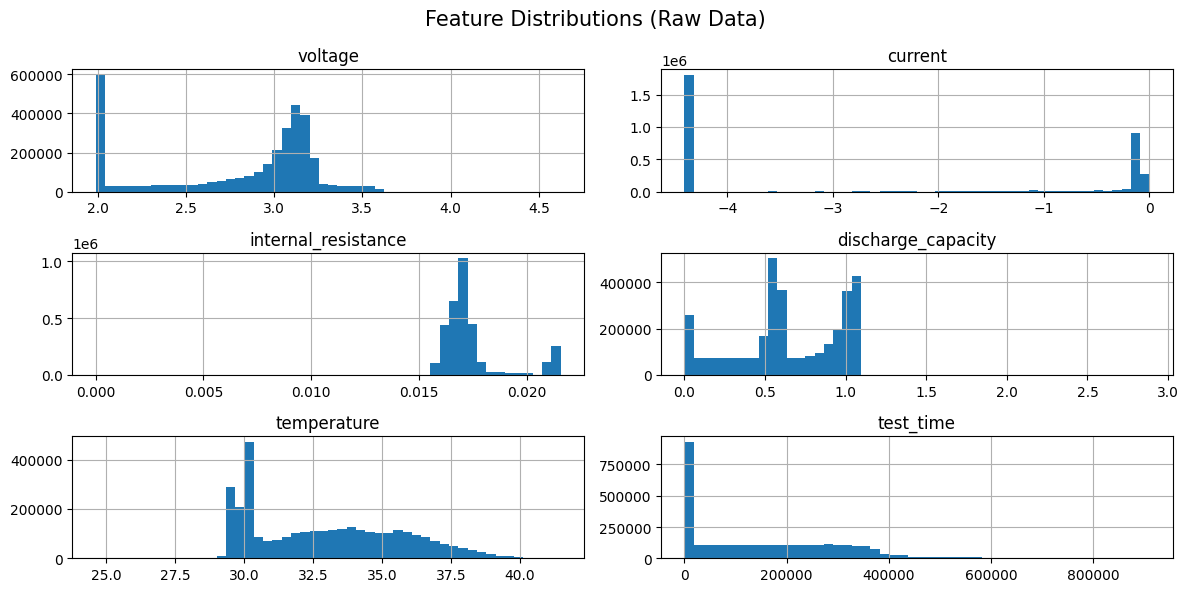

In [13]:
#Plotting Feature Distribution 
df[features_to_check].hist(bins=50, figsize=(12, 6))
plt.suptitle('Feature Distributions (Raw Data)', fontsize=15)
plt.tight_layout()
plt.show()

In [14]:
###### TRAINIING AN Ensemble-Based Anomaly Detection Model : -Rolling Z-score + Isolation Forest + Local Outlier Factor (LOF) 
# Step 1: Prepare your dataset
features = ['voltage', 'current', 'internal_resistance', 'temperature', 'discharge_capacity', 'test_time']
df_filtered = df[features + ['is_anomaly_stat']].dropna().copy()
X = df_filtered[features]
y_true = df_filtered['is_anomaly_stat'].astype(int)

In [15]:
# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# ⚠Step 3: Model 1 - Isolation Forest
iso_model = IsolationForest(n_estimators=500, contamination=0.008, random_state=42)
iso_pred = pd.Series((iso_model.fit_predict(X_scaled) == -1).astype(int), index=df_filtered.index)

In [17]:
# Step 4: Model 2 - Local Outlier Factor
lof_model = LocalOutlierFactor(n_neighbors=40, contamination=0.008)
lof_pred = pd.Series((lof_model.fit_predict(X_scaled) == -1).astype(int), index=df_filtered.index)

In [18]:
# Step 5: Model 3 - Rolling Z-score (already in 'is_anomaly_stat')
zscore_pred = df_filtered['is_anomaly_stat'].astype(int)

In [19]:
# Step 6: Weighted Ensemble (Z-score 0.5, LOF 0.3, ISO 0.2)
weighted_votes = (
    0.5 * zscore_pred +
    0.3 * lof_pred +
    0.2 * iso_pred
)
ensemble_pred = (weighted_votes >= 0.5).astype(int)

In [20]:
# Step 7: Evaluation
conf_matrix = confusion_matrix(y_true, ensemble_pred)
report = classification_report(y_true, ensemble_pred, target_names=["Normal", "Anomaly"])

print("Confusion Matrix (Weighted Ensemble):")
print(pd.DataFrame(conf_matrix, index=['Actual Normal', 'Actual Anomaly'],
                   columns=['Predicted Normal', 'Predicted Anomaly']))

print("\nClassification Report:")
print(report)

Confusion Matrix (Weighted Ensemble):
                Predicted Normal  Predicted Anomaly
Actual Normal            3229350                 43
Actual Anomaly                 0              17114

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00   3229393
     Anomaly       1.00      1.00      1.00     17114

    accuracy                           1.00   3246507
   macro avg       1.00      1.00      1.00   3246507
weighted avg       1.00      1.00      1.00   3246507



In [21]:
# Step 8: Anomaly Summary
summary_table = ensemble_pred.value_counts().rename(index={0: 'Normal', 1: 'Anomaly'})
print("\nAnomaly Summary Table (Weighted Ensemble):")
print(summary_table)


Anomaly Summary Table (Weighted Ensemble):
Normal     3229350
Anomaly      17157
Name: count, dtype: int64


In [22]:
#####PART TWO : - Analyzing and interpreting the measurement data for identifying trends and pattern
#after improving quality of data using rolling z-score and 
#training models based on essembly system (Ensemble-Based Anomaly Detection : -Rolling Z-score + Isolation Forest + Local Outlier Factor (LOF)).

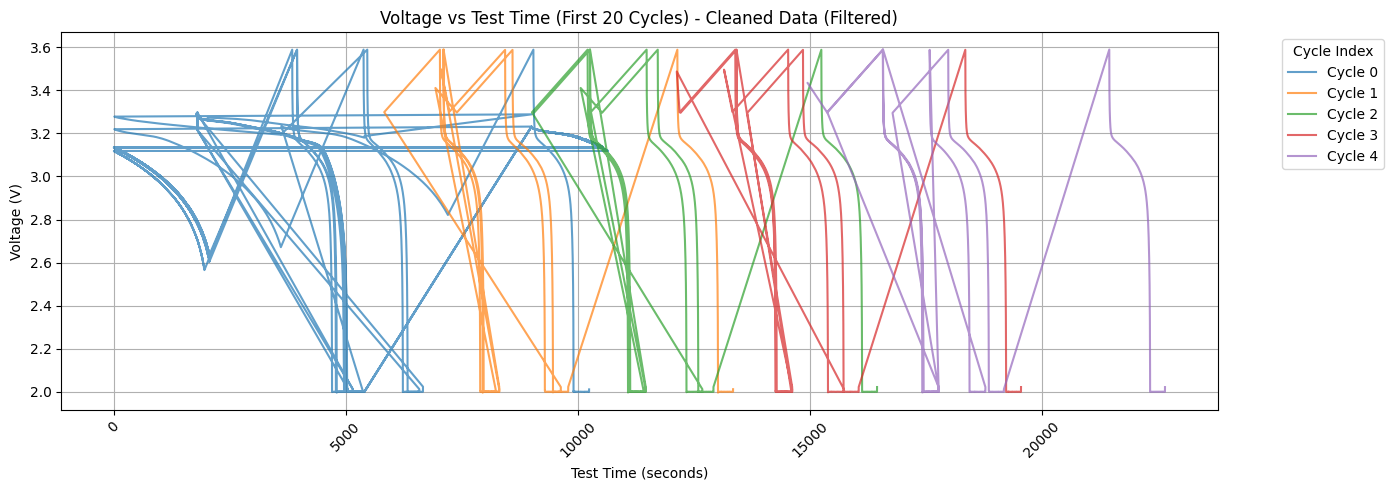

In [37]:
#Graph1: - Voltage vs Test Time for First 10 Cycles (Sampled & Cleaned)
# Filter the first 10 cycles from cleaned data
subset = df_clean[df_clean['cycle_index'] < 5]

# Optional: filter out unusually high test_time values (you can tweak this threshold)
subset = subset[subset['test_time'] <= 100000]  # Adjust based on your data distribution

# Plot
plt.figure(figsize=(14, 5))

for cycle in sorted(subset['cycle_index'].unique()):
    cycle_data = subset[subset['cycle_index'] == cycle]
    plt.plot(cycle_data['test_time'], cycle_data['voltage'], label=f'Cycle {cycle}', alpha=0.7)

plt.xlabel("Test Time (seconds)")
plt.ylabel("Voltage (V)")
plt.title("Voltage vs Test Time (First 20 Cycles) - Cleaned Data (Filtered)")

plt.xticks(rotation=45)
plt.legend(title="Cycle Index", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

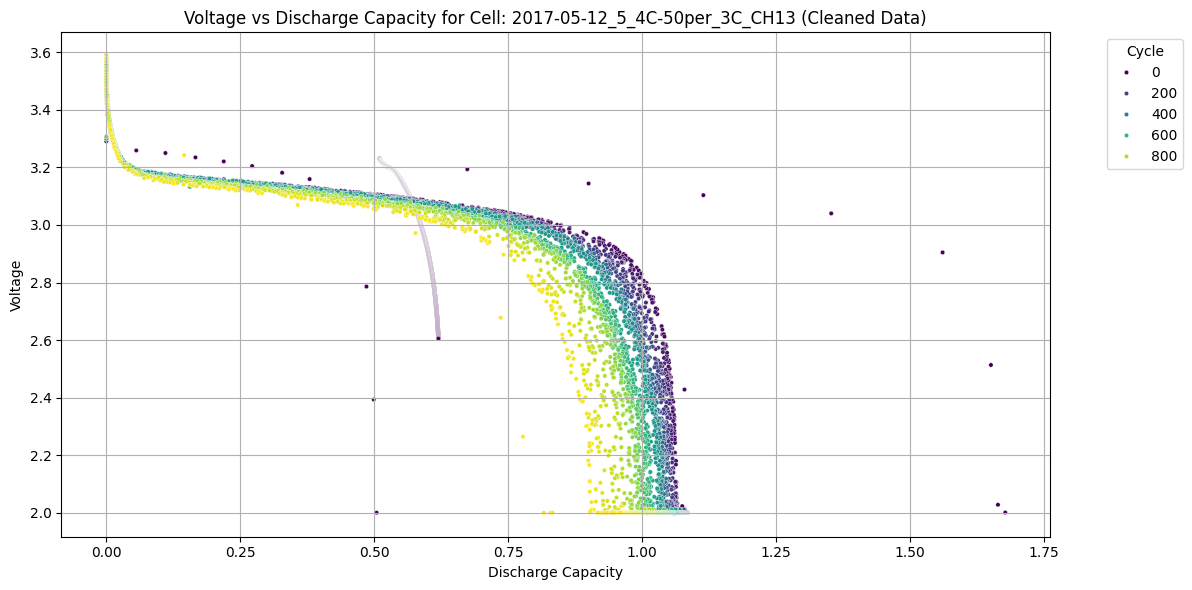

In [25]:
#Graph2: - Discharge Capacity vs Voltage (Sampled & Cleaned, A Clustered Graph)
#Discharge Capacity vs Voltage Colored by Cycle (Single Cell, Sampled)
#Graph of Voltage vs Discharge Capacity (coloured by cycles). This is the same graph as below but it is clustered more.
cell_id = df_clean['cell_index'].unique()[0]  # pick the first available cell
sampled_single_cell = df_clean[df_clean['cell_index'] == cell_id].iloc[::50]  # sample every 50 rows
# Plot Voltage vs Discharge Capacity, colored by Cycle
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=sampled_single_cell,
    x='discharge_capacity',
    y='voltage',
    hue='cycle_index',
    palette='viridis',
    s=10
)
plt.title(f"Voltage vs Discharge Capacity for Cell: {cell_id} (Cleaned Data)")
plt.xlabel("Discharge Capacity")
plt.ylabel("Voltage")
plt.legend(title='Cycle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\rsodh\AppData\Local\Temp\ipykernel_40052\1404733337.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_cell_df = filtered_cell_df.groupby('cycle_index').apply(lambda x: x.iloc[::10]).reset_index(drop=True)


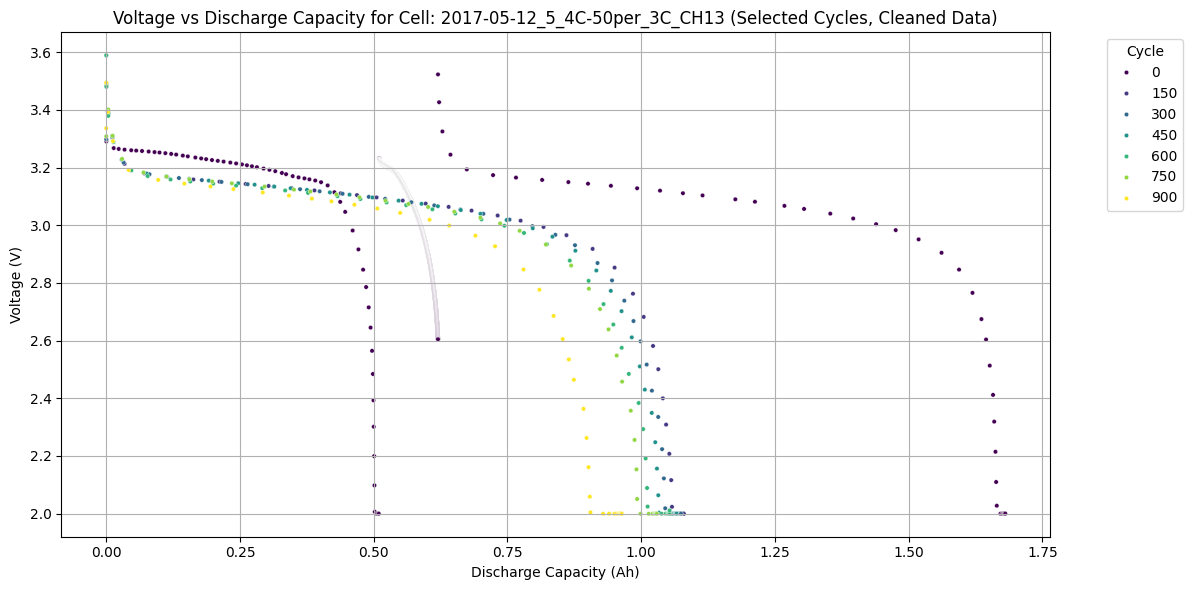

In [26]:
#Graph3: - Discharge Capacity vs Voltage (Sampled & Cleaned, A more Precise Graph)
#Discharge Capacity vs Voltage Colored by Cycle (Single Cell, Sampled)
#Graph of Voltage vs Discharge Capacity (coloured by cycles). This is the same graph as below but it is clustered more.
selected_cycles = [0, 150, 300, 450, 600, 750, 900]

# Filter the cleaned data
filtered_cell_df = df_clean[
    (df_clean['cell_index'] == cell_id) &
    (df_clean['cycle_index'].isin(selected_cycles))
]

# Sample within each cycle (preserve structure)
sampled_cell_df = filtered_cell_df.groupby('cycle_index').apply(lambda x: x.iloc[::10]).reset_index(drop=True)

# Plot Voltage vs Discharge Capacity, colored by selected cycles
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=sampled_cell_df,
    x='discharge_capacity',
    y='voltage',
    hue='cycle_index',
    palette='viridis',
    s=10
)

plt.title(f"Voltage vs Discharge Capacity for Cell: {cell_id} (Selected Cycles, Cleaned Data)")
plt.xlabel("Discharge Capacity (Ah)")
plt.ylabel("Voltage (V)")
plt.legend(title='Cycle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

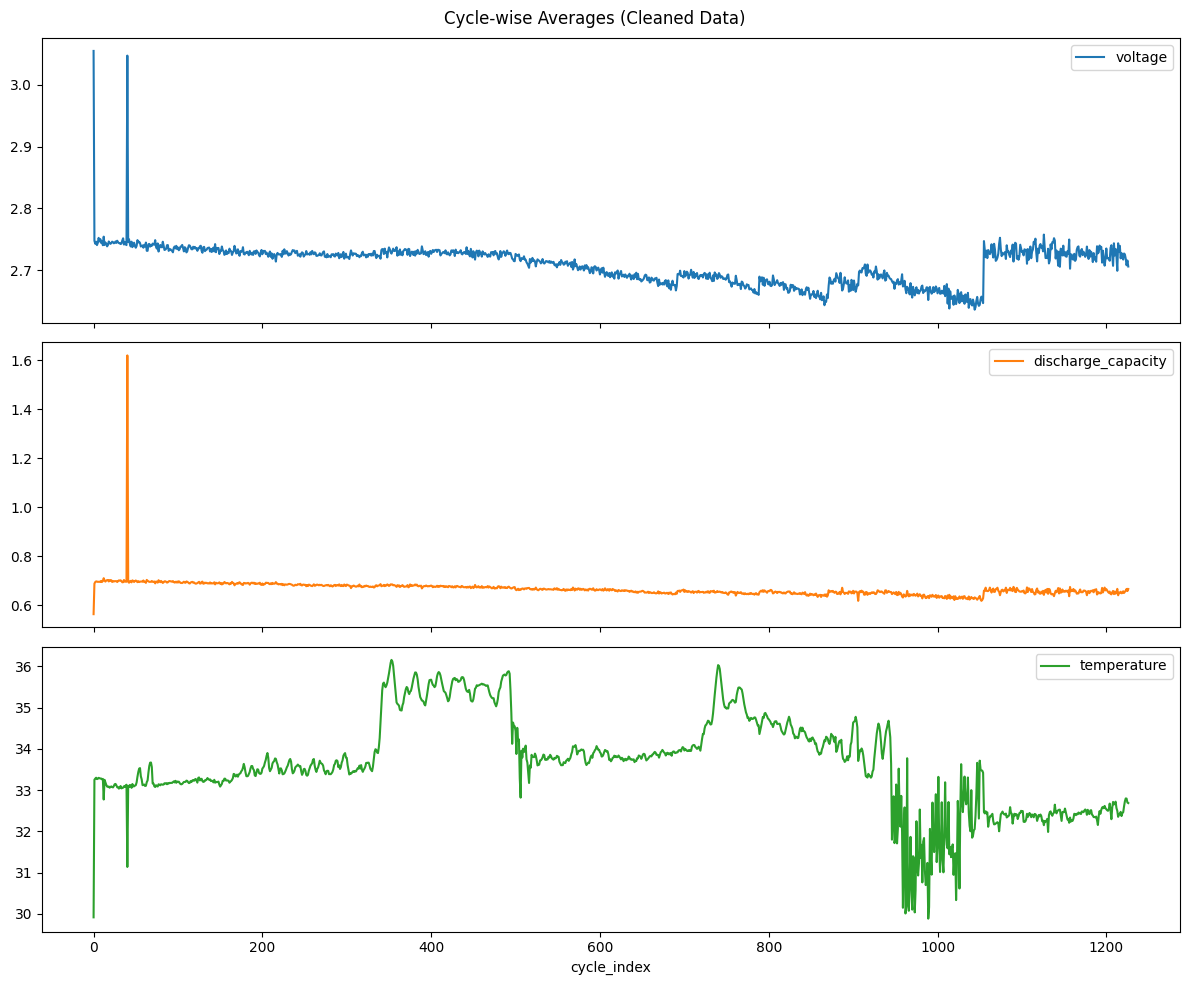

In [27]:
#Graph4: - Discharge Capacity vs Voltage (Sampled & Cleaned)
#Voltage vs cycle graph (blue): The battery initially performs well, however gradually loses voltage performance due to aging and stress.
#Average discharge capacity per cycle (orange): The battery is losing its ability to store energy, a typical sign of battery aging or wear.
#Average temperature per cycle (green): High temperatuer might indicate increased internal resistance, heavy stress/load and inefficient cooling.
# Group by cycle and calculate mean of selected features using cleaned data
grouped = df_clean.groupby("cycle_index")[["voltage", "discharge_capacity", "temperature"]].mean()

# Plot all three as subplots
grouped.plot(subplots=True, figsize=(12, 10), title="Cycle-wise Averages (Cleaned Data)")
plt.tight_layout()
plt.show()

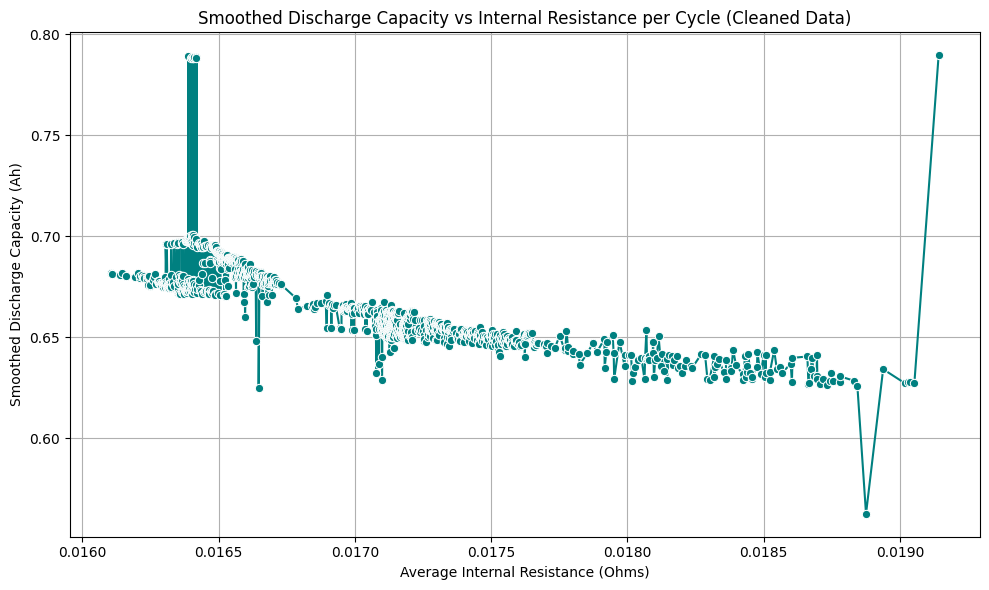

In [28]:
#Graph5: -Discharge capacity vs Internal resistance
#As the battery gets older, its internal resistance increases, and this makes it harder for the battery to give out power.
#So, it starts holding less and less charge.
# Use only discharge-phase data from the cleaned dataset
df_discharge = df_clean[df_clean['current'] < 0]

#Group by cycle and calculate average internal resistance and discharge capacity
grouped = df_discharge.groupby('cycle_index')[['internal_resistance', 'discharge_capacity']].mean().reset_index()

# Apply rolling average smoothing to discharge capacity
grouped['discharge_capacity_smoothed'] = grouped['discharge_capacity'].rolling(window=10, min_periods=1).mean()

#  Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=grouped,
    x='internal_resistance',
    y='discharge_capacity_smoothed',
    marker='o',
    color='teal'
)

plt.title("Smoothed Discharge Capacity vs Internal Resistance per Cycle (Cleaned Data)")
plt.xlabel("Average Internal Resistance (Ohms)")
plt.ylabel("Smoothed Discharge Capacity (Ah)")
plt.grid(True)
plt.tight_layout()
plt.show()

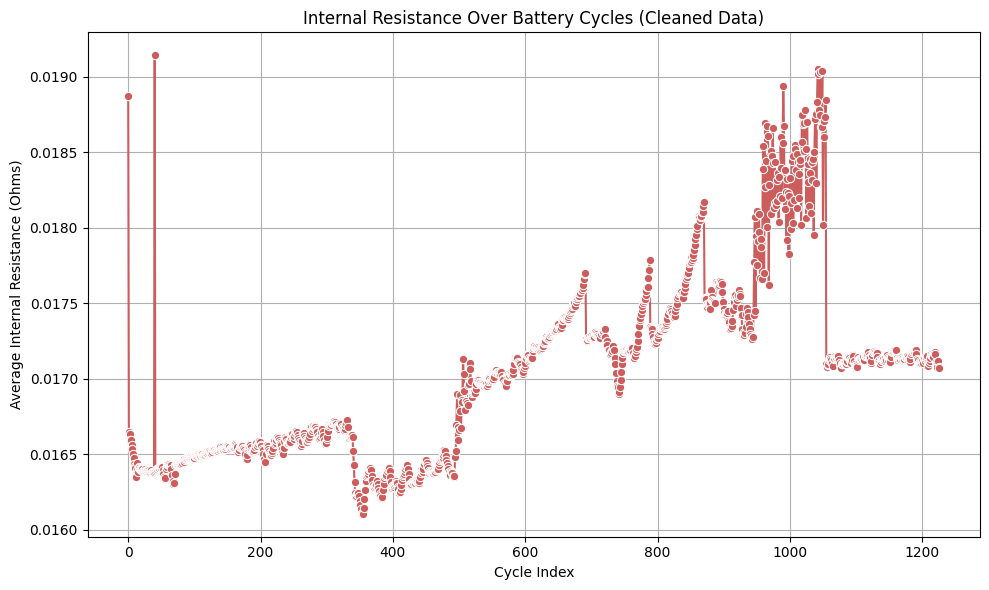

In [29]:
#Graph 6: - Average Internal Resistance vs Battery Cycles (Averaged Per Cycle) —
#This graph tells you how the battery's internal resistance increases over time, which is a key indicator of aging and wear.
#As the battery is used more and more (more cycles), its internal resistance gets worse — meaning it’s harder for energy to flow, which leads to poorer performance, more heat, and lower capacity.
# Use only discharge-phase data from the cleaned dataset
df_discharge = df_clean[df_clean['current'] < 0]

# Group by cycle index and calculate average internal resistance
resistance_per_cycle = df_discharge.groupby('cycle_index')['internal_resistance'].mean().reset_index()

# Plot the trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=resistance_per_cycle, x='cycle_index', y='internal_resistance', marker='o', color='indianred')

plt.title("Internal Resistance Over Battery Cycles (Cleaned Data)")
plt.xlabel("Cycle Index")
plt.ylabel("Average Internal Resistance (Ohms)")
plt.grid(True)
plt.tight_layout()
plt.show()

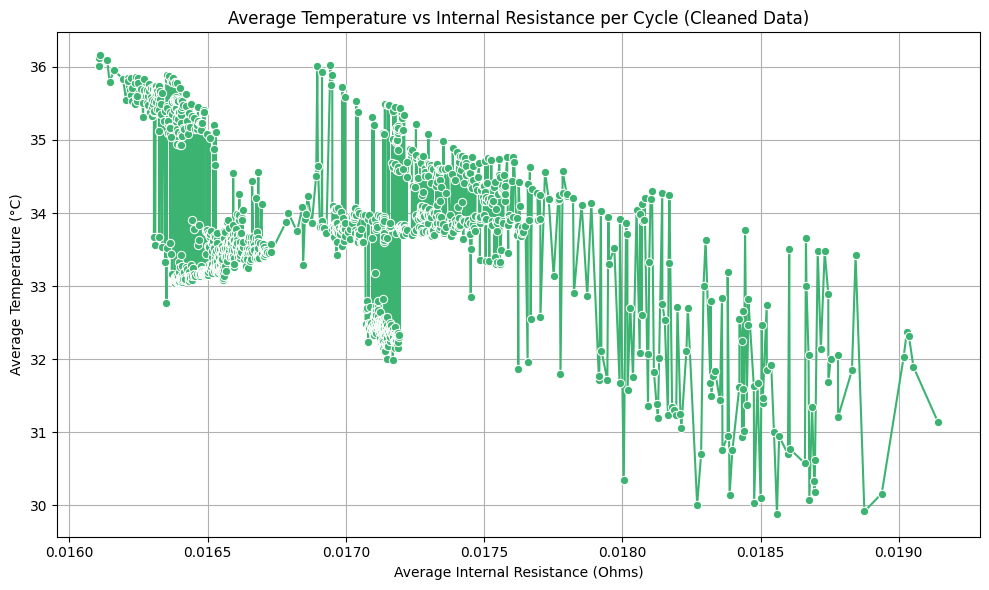

In [30]:
# Graph 7: - Average Internal resistance vs Average Temperature.
#Battery aging → less current → less heat. The battery is struggling and not pushing much current anymore, so temperature drops.
#The battery’s resistance goes up as it gets older, but its temperature doesn't always rise with it.
#In fact, near the end, it cools down — probably because it’s too weak to deliver much power anymore.
# Use only discharge-phase data from cleaned dataset
df_discharge = df_clean[df_clean['current'] < 0]

#Group by cycle to get average internal resistance and temperature
grouped_temp_res = df_discharge.groupby('cycle_index')[['internal_resistance', 'temperature']].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=grouped_temp_res,
    x='internal_resistance',
    y='temperature',
    marker='o',
    color='mediumseagreen'
)

plt.title("Average Temperature vs Internal Resistance per Cycle (Cleaned Data)")
plt.xlabel("Average Internal Resistance (Ohms)")
plt.ylabel("Average Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

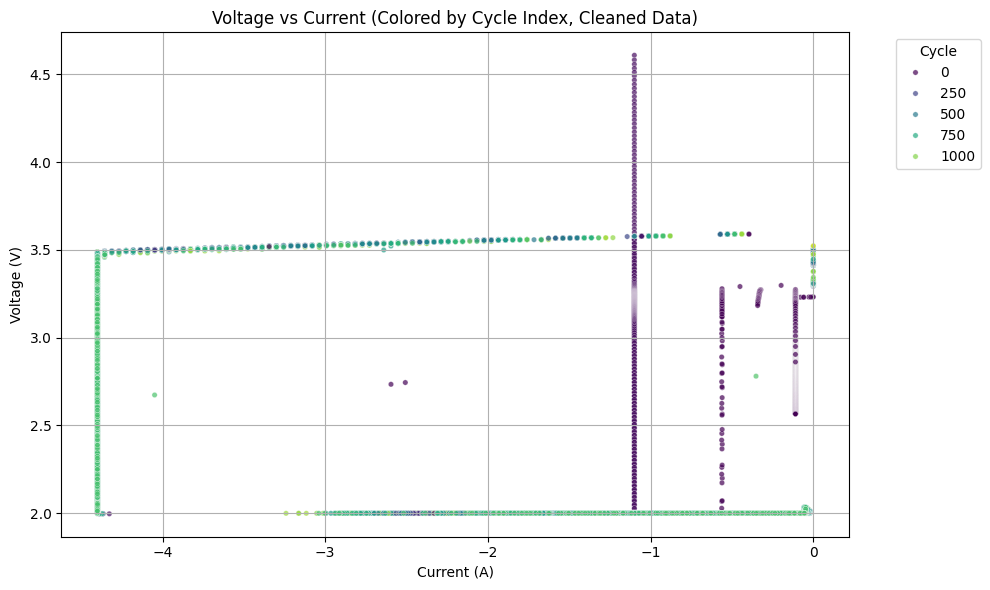

In [31]:
#Graph 8: - Voltage vs Current (Coloured by Cycles)
#This plot shows how the battery voltage behaves under different discharge currents.
#The more the battery ages (color shift from dark to light), the more it struggles to maintain high voltage during discharge — a sign of degradation.
#  Filter only discharge-phase data from cleaned dataset
df_discharge = df_clean[df_clean['current'] < 0]

#  Sample every 20th row for better clarity
sampled_df = df_discharge.iloc[::20]

#  Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sampled_df,
    x='current',
    y='voltage',
    hue='cycle_index',
    palette='viridis',
    s=15,
    alpha=0.7
)

plt.title("Voltage vs Current (Colored by Cycle Index, Cleaned Data)")
plt.xlabel("Current (A)")
plt.ylabel("Voltage (V)")
plt.legend(title="Cycle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()